## Random Forest | Multivariate

In [1]:
# general import environment
print('versions')
print ('------------')
import pandas as pd
print('pandas: ', pd.__version__)
pd.set_option('display.max_columns', None)
import numpy as np
print('numpy: ', np.__version__)
import time as time
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
print('mpl: ', mpl.__version__)
%matplotlib inline

from sklearn.metrics import mean_squared_error

versions
------------
pandas:  0.20.3
numpy:  1.13.3
mpl:  2.0.2


In [2]:
# anchor random seed
np.random.seed(1)
rs = 1

### load cached data

In [3]:
#### load cached data
temporal_group = 'weekly'
df = pd.read_csv('data/historical_data_{0}.csv'.format(temporal_group))

# force convert string dates to dt objects & set index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [4]:
# dropping front end of curve, dampens predictive power
drop_list = ['FEDFUNDS','DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3']
for drop_x in drop_list:
    df.drop(drop_x, axis=1, inplace=True)

In [5]:
# set list of columns/points on yield curve used
col_list = list(df.columns.values)
print(col_list)

['DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']


### model params

In [6]:
# set lookback/forward windows for lagged timeseries
lookforward_window = 1
lookback_window = 6

In [7]:
# identify single column to target
target_column = 'DGS30'
col_list.remove(target_column)

In [8]:
# generic title list, used for renaming/reordering columns after lag/lead feature generation
rename_list = ['aa','bb','cc','dd','ee','ff','gg','hh','ii','jj','kk','ll','mm','nn','oo','pp','qq','rr','ss']

### preprocess data

In [9]:
# separate out target column, rename columns w/ generic title  |  [target = 't']
base_col = 't'
df.rename(columns={target_column: base_col}, inplace=True)

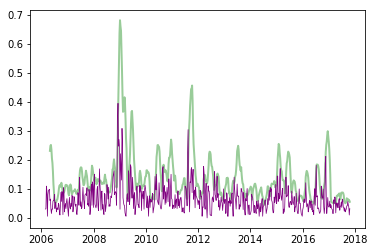

In [10]:
# examine rolling volatility
plt.plot(df[base_col].rolling(window=12).std(),color='green',lw=2.0,alpha=0.4)
plt.plot(df[base_col].rolling(window=3).std(),color='purple',lw=0.75)
plt.show;

In [11]:
# rename non-target columns
for col_x in np.arange(len(col_list)):
    df.rename(columns={col_list[col_x]: rename_list[col_x]}, inplace=True)

In [12]:
# create list of columns to lag
lag_list = list(df.columns.values)

In [13]:
# create target vector(s) | lookforward window
for iter_x in np.arange(lookforward_window)+1:
    df['y+{0}'.format(str(iter_x))] = df[base_col].shift(-iter_x)

In [14]:
print(df.shape)
# df.tail(2)

(611, 6)


In [15]:
# generate lag'd features | 1st layer iterate over target columns, 2nd layer lags up to specified window limit
print(df.shape)
for col_x in lag_list:
    # create lagged autoregressive features
    for iter_x in np.arange(lookback_window)+1:
        df['{0}-{1}'.format(col_x,   str(iter_x).zfill(2)      )] = df[col_x].shift(iter_x)
print(df.shape)

(611, 6)
(611, 36)


In [16]:
# change column order | target vector(s) first for model consistency
col_list = list(df.columns.values)
lookforward_cols = []
for iter_x in col_list:
    if 'y' in iter_x:
        lookforward_cols.append(iter_x)
for iter_x in lookforward_cols:
    col_list.remove(iter_x)
col_list.sort()    

#reverse lookforward window order to reverse sequential consistency  | lookforward_cols[::-1]
col_list = lookforward_cols + col_list
df = df[col_list].copy()

In [17]:
# review small df window after engineering lagged features/target vector(s)
df.iloc[(len(df)-lookforward_window)-2:(len(df)-lookforward_window),:]

,y+1,aa,aa-01,aa-02,aa-03,aa-04,aa-05,aa-06,bb,bb-01,bb-02,bb-03,bb-04,bb-05,bb-06,cc,cc-01,cc-02,cc-03,cc-04,cc-05,cc-06,dd,dd-01,dd-02,dd-03,dd-04,dd-05,dd-06,t,t-01,t-02,t-03,t-04,t-05,t-06
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-08,2.88,1.94,1.89,1.88,1.78,1.65,1.72,1.77,2.17,2.13,2.10,2.01,1.90,1.97,2.00,2.34,2.31,2.26,2.20,2.07,2.15,2.18,2.64,2.62,2.57,2.52,2.43,2.49,2.52,2.87,2.86,2.80,2.77,2.69,2.75,2.77
2017-10-15,2.82,1.95,1.94,1.89,1.88,1.78,1.65,1.72,2.17,2.17,2.13,2.10,2.01,1.90,1.97,2.35,2.34,2.31,2.26,2.20,2.07,2.15,2.64,2.64,2.62,2.57,2.52,2.43,2.49,2.88,2.87,2.86,2.80,2.77,2.69,2.75


In [18]:
# create df copy for use w/ predictions
tail = df.copy()
# tail.tail(2)

In [19]:
# drop NaNs created from lagged feature generation
df = df.dropna().copy()

In [20]:
# missing value check
check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))
print(np.sum(check_null.values) == 0.0)

True


In [21]:
# set timeseries data
data = df.values

In [22]:
# partition data into train/test sets
split_pct=0.75
train_test_cut_period = int(len(data)*split_pct) #split point
train_set = data[:train_test_cut_period].copy()
test_set = data[train_test_cut_period:].copy()

In [23]:
# partition target vector(s) | input vetor(s)
X_train = train_set[:,lookforward_window:].copy()
y_train = train_set[:,:lookforward_window].copy()

X_test = test_set[:,lookforward_window:].copy()
y_test = test_set[:,:lookforward_window].copy()

In [24]:
from sklearn.ensemble import RandomForestRegressor
start_fit = time.time()

reg1 = RandomForestRegressor(random_state=rs, n_estimators=200, n_jobs=-1)
reg1.fit(X_train, y_train.ravel());

end_fit = time.time()

In [25]:
# wall time to train model
fit_time = (end_fit - start_fit)
print(fit_time/60.0)

0.017480719089508056


In [26]:
# coefficient of determination R^2 of the prediction.
print(reg1.score(X_train, y_train))
print(reg1.score(X_test, y_test))

0.996825619114
0.566793255041


In [27]:
# #evaluate model params (tree count)
# train_score = []
# test_score = []
# est_list = [int(x) for x in np.linspace(10,500,20)]
# for n_est_x in est_list:
#     tmp_reg = RandomForestRegressor(random_state=rs, n_estimators=n_est_x, n_jobs=-1)
#     tmp_reg.fit(X_train, y_train.ravel());
#     train_score.append(tmp_reg.score(X_train, y_train))
#     test_score.append(tmp_reg.score(X_test, y_test))    
    
# testdf = pd.DataFrame({'train':train_score,'test':test_score,'n_est':est_list})
# testdf = testdf.set_index('n_est')
# testdf['test'].plot(c='purple')
# testdf['train'].plot(c='green')    

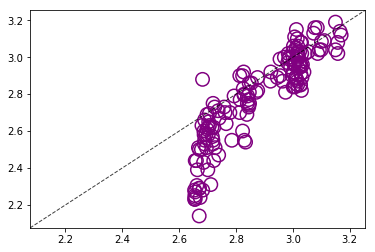

In [28]:
# spot checking prediction pattern (ideally linear)
xxx = reg1.predict(X_test)
yyy = y_test
max_show = yyy.max() + yyy.max()*.10
plt.plot([0, max_show], [0, max_show], c='k', lw=1.0, linestyle='--', alpha=0.75)
plt.scatter(xxx, yyy, s=180, facecolors='none', edgecolors='purple',lw=1.5)
plt_min = min(np.min(xxx),np.min(yyy))
plt_max = max(np.max(xxx),np.max(yyy))
plt.xlim(plt_min*.97,plt_max*1.02)
plt.ylim(plt_min*.97,plt_max*1.02)
plt.show()

In [29]:
data = df[base_col].values
training_split_cut = int(split_pct*len(df))

In [30]:
green_line = data[:training_split_cut]
purple_line = []
for iter_x in np.arange(training_split_cut):
    purple_line.append(np.nan)
purple_line = purple_line + list(reg1.predict(X_test))    

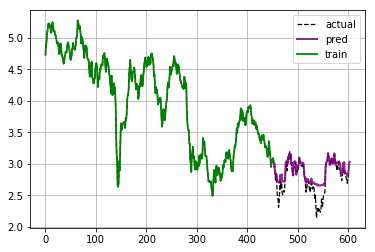

In [31]:
plt.plot(data,color='k',linestyle='--',lw=1.25)
plt.plot(purple_line, color='purple',lw=2.0,alpha=0.85)
plt.plot(green_line,color='green',lw=1.75)

plt.grid(True)
plt.legend(['actual','pred','train'], loc='best')